# Import Libraries

In [78]:
#pip install imbalanced-learn

In [185]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


# Load Data

In [202]:
surveydata = pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/surveydata.csv',
                        low_memory = False)
#data_500k=pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/data_500k.csv',
                     #low_memory = False)


# Data Cleaning

In [203]:
#Replace blanks and spaces with NaN
surveydata.replace(r'^\s*$', np.nan, regex=True, inplace=True)
#data_500k.replace(r'^\s*$', np.nan, regex=True, inplace=True)



In [204]:
#fill missing values, using median / mode data

replacements = {
    'CENSUS_TRK': '000000',
    'AGE': surveydata['AGE'].median(),
    'CNS_MEDINC': surveydata['CNS_MEDINC'].mode()[0],
    'CNSUS_PCTA': surveydata['CNSUS_PCTA'].median(),
    'CNSUS_PCTB':surveydata['CNSUS_PCTB'].median(),
    'CNSUS_PCTH':surveydata['CNSUS_PCTH'].median(),
    'CNSUS_PCTI':surveydata['CNSUS_PCTI'].median(),
    'CNSUS_PCTM':surveydata['CNSUS_PCTM'].median(),
    'CNSUS_PCTO':surveydata['CNSUS_PCTO'].median(),
    'CNSUS_PCTP':surveydata['CNSUS_PCTP'].median(), 
    'CNSUS_PCTW':surveydata['CNSUS_PCTW'].median(), 
    'CONG_DIST': '000',
    'COUNTY_TYPE': 'UNK',
    'DON_POLIT': 'N',
    'DON_CHARIT':'N',
    'DON_RELIG':'N',
    'DON_HEALTH':'N',
    'PRFL_ENVIRONMENT':'N',
    'EDUCATION': surveydata['EDUCATION'].mode()[0],
    'ETHNIC_INFER': surveydata['ETHNIC_INFER'].mode()[0],
    'HOMEMKTVAL': surveydata['HOMEMKTVAL'].mode()[0],
    'HOMEOWNRNT':surveydata['HOMEOWNRNT'].mode()[0],
    'INCOMESTHH':surveydata['INCOMESTHH'].mode()[0],
    'LIFESTAGE_CLUSTER':'UNK',
    'LANGUAGE':'UNK',
    'NETWORTH':surveydata['NETWORTH'].mode()[0],
    'PRESENCHLD':'N',
    'PRFL_VETERAN':'N',
    'PRFL_2NDAMEND':'N',
    'PRFL_BIDEN_SUPPORT':'N',
    'PRFL_BORDER_SECURITY':'N',
    'PRFL_EVANGELICAL':'N',
    'PRFL_IMMIGRATION_REFORM':'N',
    'PRFL_POLITICAL_IDEOLOGY':'UNK',
    'PRFL_ANML_RIGHTS':'N',
    'PRFL_EDUCATION':'N',
    'PRFL_GUN_CONTROL':'N',
    'PRFL_TRUMP_SUPPORT':'N',
    'PRFL_FENCE_SITTER':'N',
    'PRFL_PERSUADABLE_VOTER':'N',
    'PRFL_MARRIAGE_EQUALITY':0,
    'PRFL_METOO_SUPPORT':'N',
    'PRFL_MIL_SUPPORT':'N',
    'PRFL_MINWAGE':0,
    'PRFL_CHOICELIFE':0,
    'RELIGION':surveydata['RELIGION'].mode()[0],
    'SEX':'UNK',
    'ST_LO_HOUS':'000',
    'ST_UP_HOUS':'00',
    'TOD_PRES_D_2016': surveydata['TOD_PRES_D_2016'].median(),
    'TOD_PRES_D_2016_PREC': surveydata['TOD_PRES_D_2016_PREC'].median(),
    'TOD_PRES_D_2020_PREC' : surveydata['TOD_PRES_D_2020_PREC'].median(),
    'TOD_PRES_O_2016' : surveydata['TOD_PRES_O_2016'].median(),
    'TOD_PRES_O_2016_PREC': surveydata['TOD_PRES_O_2016_PREC'].median(),
    'TOD_PRES_O_2020_PREC': surveydata['TOD_PRES_O_2020_PREC'].median(),
    'TOD_PRES_R_2016' : surveydata['TOD_PRES_R_2016'].median(),
    'TOD_PRES_R_2016_PREC': surveydata['TOD_PRES_R_2016_PREC'].median(),
    'TOD_PRES_R_2020_PREC': surveydata['TOD_PRES_R_2020_PREC'].median(),
    'ZIP': '-9999'
}

# Fill NaNs
for col, value in replacements.items():
    surveydata[col].fillna(value, inplace=True)

In [205]:
#feature engineering

# R_donor
surveydata['R_DONOR'] = ((surveydata['FUND_POLIT'] == 'R') | (surveydata['DON_POLCONS'] > '')).astype(int)

# D_donor
surveydata['D_DONOR'] = ((surveydata['FUND_POLIT'] == 'D') | (surveydata['DON_POLLIB'] > '')).astype(int)

# Voted_R_Election
vtr_columns_r = [col for col in surveydata.columns if col.startswith('VTR_')]
condition_r = surveydata[vtr_columns_r].isin(['R', 'P', 'X']).any(axis=1)
surveydata['VOTED_R_ELECTION'] = condition_r.astype(int)

# Voted_D_Election
vtr_columns_d = [col for col in surveydata.columns if col.startswith('VTR_')]
condition_d = surveydata[vtr_columns_d].isin(['D', 'M', 'Z']).any(axis=1)
surveydata['VOTED_D_ELECTION'] = condition_d.astype(int)

#additional engineered features to make unique county , congressional , state upper house & state lower house columns
#because county , congressional and house district codes repeat across states
surveydata['STATE_COUNTY_FIPS'] = surveydata['CENSUS_ST'].astype(str) + surveydata['COUNTY_ST'].astype(str)
surveydata['STATE_CD'] = surveydata['CENSUS_ST'].astype(str) + surveydata['CONG_DIST'].astype(str)
surveydata['STATE_LOWER_HOUSE'] = surveydata['CENSUS_ST'].astype(str) + surveydata['ST_LO_HOUS'].astype(str)
surveydata['STATE_UPPER_HOUSE'] = surveydata['CENSUS_ST'].astype(str) + surveydata['ST_UP_HOUS'].astype(str)
surveydata['CENSUS_TRACT'] = surveydata['CENSUS_ST'].astype(str) + surveydata['COUNTY_ST'].astype(str)+ surveydata['CENSUS_TRK'].astype(str)

#add a feature for number of absentee votes
vtr_columns = [col for col in surveydata.columns if col.startswith('VTR_')]
surveydata['ABSENTEE_VOTES'] = surveydata[vtr_columns].apply(lambda row: sum(row.isin(['A', 'X', 'Z'])), axis=1)

#add a feature for number of primary votes
vtr_p_columns = [col for col in surveydata.columns if col.startswith('VTR_P')]
surveydata['NUM_PRIMARY_VOTES'] = surveydata[vtr_p_columns].apply(lambda row: row.notna().sum(), axis=1)

C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_28340\247914000.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  surveydata['R_DONOR'] = ((surveydata['FUND_POLIT'] == 'R') | (surveydata['DON_POLCONS'] > '')).astype(int)
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_28340\247914000.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  surveydata['D_DONOR'] = ((surveydata['FUND_POLIT'] == 'D') | (surveydata['DON_POLLIB'] > '')).astype(int)


In [206]:
surveydata['Q1_Candidate'].value_counts()

President Donald Trump            493
President Joe Biden               492
Governor Ron DeSantis             117
Undecided                          98
Nikki Haley                        82
Robert F. Kennedy Jr.              56
Vice-President Mike Pence          47
Governor Chris Christie            42
Other - Write In                   34
Vivek Ramaswamy                    34
Senator Tim Scott                  32
Marianne Williamson                16
Governor Gavin Newsom               7
Governor Doug Burgum                4
Former Governor Asa Hutchinson      2
Former Congressman Will Hurd        2
Mayor Francis Suarez                1
Larry Elder                         1
Name: Q1_Candidate, dtype: int64

In [191]:
#surveydata = surveydata[~surveydata['Q1_Candidate'].isin(['Larry Elder', 'Mayor Francis Suarez',
                                       # 'Former Governor Asa Hutchinson','Former Congressman Will Hurd',
                                                      #   'Governor Doug Burgum','Marianne Williamson',
                                                       #  'Other - Write In','Undecided','Senator Tim Scott','Vivek Ramaswamy',
                                                       #  'Governor Gavin Newsom'])]

In [192]:
#can't get the models to predict any of the classes besides trump and biden, so doing the below instead

In [207]:
#consolidate target column 

candidates_to_replace1 = [
    "Governor Doug Burgum",
    "Former Governor Asa Hutchinson",
    "Former Congressman Will Hurd",
    "Larry Elder",
    "Mayor Francis Suarez",
    "Governor Ron DeSantis",
    "Nikki Haley",
    "Vice-President Mike Pence",
    "Governor Chris Christie",
    "Vivek Ramaswamy",
    "Senator Tim Scott"]

# Replacing the specified values with "Other GOP"
surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace1, "Other GOP")

candidates_to_replace2 = ["Robert F. Kennedy Jr.", "Marianne Williamson", "Governor Gavin Newsom"]
surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace2, "Other DEM")

candidates_to_replace3 =["Other - Write In", "Undecided"]

surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace3, "Other/Undecided")

surveydata['Q1_Candidate'].value_counts()

#lets drop the 2 smallest categories and see if performance on the top 3 improves
surveydata = surveydata[~surveydata['Q1_Candidate'].isin(['Other/Undecided', 'Other DEM'])]

In [208]:
surveydata['Q1_Candidate'].value_counts()

President Donald Trump    493
President Joe Biden       492
Other GOP                 364
Name: Q1_Candidate, dtype: int64

# Preprocessing

In [210]:
columns_to_use = [
    'AGE', 'CNS_MEDINC', 'CNSUS_PCTA', 'CNSUS_PCTB',
    'CNSUS_PCTH', 'CNSUS_PCTI', 'CNSUS_PCTM', 'CNSUS_PCTO', 'CNSUS_PCTP', 'CNSUS_PCTW',
    'COUNTY_TYPE', 'DON_POLIT', 'EDUCATION', 'ETHNIC_INFER',
    'HOMEMKTVAL', 'HOMEOWNRNT', 'INCOMESTHH', 'NETWORTH',
    'PARTY_CODE', 'PARTY_MIX', 'PRESENCHLD', 'PRFL_POLITICAL_IDEOLOGY',
    'RELIGION', 'SEX', 'CENSUS_ST', 'LANGUAGE',
    'TOD_PRES_D_2016', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_D_2020_PREC', 'TOD_PRES_O_2016',
    'TOD_PRES_O_2016_PREC', 'TOD_PRES_O_2020_PREC', 'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC',
    'TOD_PRES_R_2020_PREC', 'ZIP', 'R_DONOR', 'D_DONOR', 'VOTED_R_ELECTION', 'VOTED_D_ELECTION',
    'STATE_COUNTY_FIPS', 'STATE_CD', 'STATE_LOWER_HOUSE', 'STATE_UPPER_HOUSE', 'CENSUS_TRACT',
    'PRFL_2NDAMEND','PRFL_BIDEN_SUPPORT','PRFL_BORDER_SECURITY','PRFL_EVANGELICAL',
    'PRFL_IMMIGRATION_REFORM','PRFL_TRUMP_SUPPORT',  'DON_CHARIT','DON_RELIG','LIFESTAGE_CLUSTER','PRFL_FENCE_SITTER',
    'PRFL_PERSUADABLE_VOTER','ABSENTEE_VOTES','NUM_PRIMARY_VOTES','PRFL_CHOICELIFE', 'PRFL_ENVIRONMENT',
    'PRFL_MARRIAGE_EQUALITY','PRFL_METOO_SUPPORT','PRFL_MIL_SUPPORT','PRFL_MINWAGE',
    'DON_HEALTH','Q1_Candidate']


features_to_use = [
        'AGE', 'CNS_MEDINC', 'CNSUS_PCTA', 'CNSUS_PCTB',
    'CNSUS_PCTH', 'CNSUS_PCTI', 'CNSUS_PCTM', 'CNSUS_PCTO', 'CNSUS_PCTP', 'CNSUS_PCTW',
    'COUNTY_TYPE', 'DON_POLIT', 'EDUCATION', 'ETHNIC_INFER',
    'HOMEMKTVAL', 'HOMEOWNRNT', 'INCOMESTHH', 'NETWORTH',
    'PARTY_CODE', 'PARTY_MIX', 'PRESENCHLD', 'PRFL_POLITICAL_IDEOLOGY',
    'RELIGION', 'SEX', 'CENSUS_ST', 'LANGUAGE',
    'TOD_PRES_D_2016', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_D_2020_PREC', 'TOD_PRES_O_2016',
    'TOD_PRES_O_2016_PREC', 'TOD_PRES_O_2020_PREC', 'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC',
    'TOD_PRES_R_2020_PREC', 'ZIP', 'R_DONOR', 'D_DONOR', 'VOTED_R_ELECTION', 'VOTED_D_ELECTION',
    'STATE_COUNTY_FIPS', 'STATE_CD', 'STATE_LOWER_HOUSE', 'STATE_UPPER_HOUSE', 'CENSUS_TRACT',
    'PRFL_2NDAMEND','PRFL_BIDEN_SUPPORT','PRFL_BORDER_SECURITY','PRFL_EVANGELICAL',
    'PRFL_IMMIGRATION_REFORM','PRFL_TRUMP_SUPPORT',  'DON_CHARIT','DON_RELIG','LIFESTAGE_CLUSTER','PRFL_FENCE_SITTER',
    'PRFL_PERSUADABLE_VOTER','ABSENTEE_VOTES','NUM_PRIMARY_VOTES','PRFL_CHOICELIFE', 'PRFL_ENVIRONMENT', 'PRFL_MARRIAGE_EQUALITY',
    'PRFL_METOO_SUPPORT','PRFL_MIL_SUPPORT','PRFL_MINWAGE','DON_HEALTH']

survey_df = surveydata[columns_to_use]


In [211]:

label_encoder = LabelEncoder()
survey_df['Q1_Candidate_encoded'] = label_encoder.fit_transform(survey_df['Q1_Candidate'])

categorical_columns = survey_df.select_dtypes(include=['object', 'category']).columns.tolist()

label_encoders = {}
for categorical_col in categorical_columns:
    le = LabelEncoder()
    survey_df[categorical_col] = le.fit_transform(survey_df[categorical_col])
    label_encoders[categorical_col] = le


C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_28340\853304422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_df['Q1_Candidate_encoded'] = label_encoder.fit_transform(survey_df['Q1_Candidate'])
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_28340\853304422.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_df[categorical_col] = le.fit_transform(survey_df[categorical_col])
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_28340\853304422.py:9: SettingWithCopyWarning: 
A value 

# Modeling (XGBoost)

In [212]:

X = survey_df[features_to_use]
y = survey_df['Q1_Candidate_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,  
    eval_metric='mlogloss' ,enable_categorical=True
)

xgb_clf.fit(X_train, y_train)

# Making predictions
y_pred = xgb_clf.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5851851851851851
              precision    recall  f1-score   support

           0       0.40      0.25      0.31        69
           1       0.55      0.68      0.61        98
           2       0.70      0.72      0.71       103

    accuracy                           0.59       270
   macro avg       0.55      0.55      0.54       270
weighted avg       0.57      0.59      0.57       270



# Feature Importances (XGBoost)

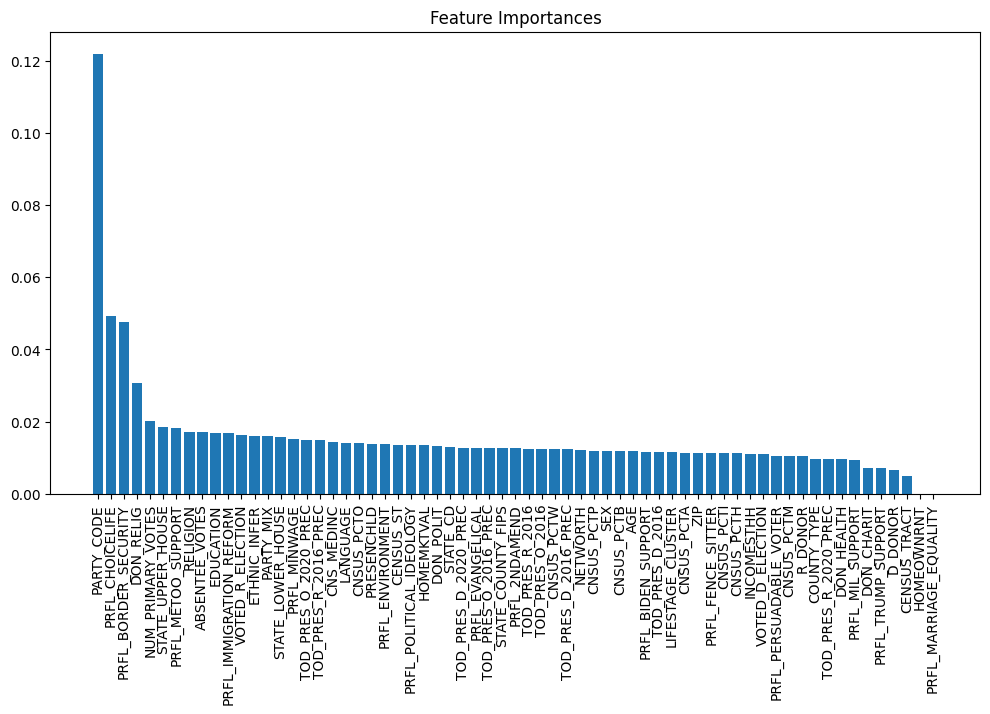

In [213]:
feature_importances = xgb_clf.feature_importances_

feature_names = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation='vertical')
plt.show()

# Parameter Tuning ( XGBoost attempt 1)

In [214]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False), param_grid, cv=3)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_

# Best parameters
print(grid.best_params_)

y_pred = best_xgb.predict(X_test)

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the detailed classification report
report = classification_report(y_test, y_pred)
print(report)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Accuracy: 60.00%
              precision    recall  f1-score   support

           0       0.53      0.14      0.23        69
           1       0.54      0.78      0.64        98
           2       0.69      0.74      0.71       103

    accuracy                           0.60       270
   macro avg       0.59      0.55      0.53       270
weighted avg       0.59      0.60      0.56       270



# Parameter Tuning (XGBoost attempt 2)

In [223]:
#this took awhile
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],
    'n_estimators': [150, 200, 250],
    'max_depth': [2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False), param_grid, cv=3)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_

# Best parameters
print(grid.best_params_)

y_pred = best_xgb.predict(X_test)

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the detailed classification report
report = classification_report(y_test, y_pred)
print(report)


{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.7}
Accuracy: 59.26%
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        69
           1       0.52      0.80      0.63        98
           2       0.68      0.77      0.72       103

    accuracy                           0.59       270
   macro avg       0.73      0.54      0.48       270
weighted avg       0.70      0.59      0.52       270



In [224]:
X = survey_df[features_to_use]
y = survey_df['Q1_Candidate_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,  
    eval_metric='mlogloss', 
    colsample_bytree=0.7, 
    gamma=1,  
    learning_rate=0.01,  
    max_depth=4, 
    n_estimators=500,  
    subsample=0.8
)


X = survey_df[features_to_use]
y = survey_df['Q1_Candidate_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf.fit(X_train, y_train)

# Making predictions
y_pred = xgb_clf.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        69
           1       0.55      0.73      0.63        98
           2       0.69      0.74      0.71       103

    accuracy                           0.60       270
   macro avg       0.58      0.56      0.54       270
weighted avg       0.59      0.60      0.57       270



# Modeling (XGBoost using SMOTE)

In [159]:
#try using SMOTE to oversample the minority class to see if that helps with performance

X = survey_df[features_to_use]
y = survey_df['Q1_Candidate_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model = XGBClassifier(objective='multi:softmax', 
    num_class=3,  
    eval_metric='mlogloss',
    enable_categorical=True,
    use_label_encoder=False)

model.fit(X_train_smote, y_train_smote)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.48148148148148145
              precision    recall  f1-score   support

           0       0.25      0.25      0.25        69
           1       0.45      0.46      0.46        98
           2       0.67      0.66      0.66       103

    accuracy                           0.48       270
   macro avg       0.46      0.46      0.46       270
weighted avg       0.48      0.48      0.48       270



# Parameter Tuning (XGBoost / SMOTE)

In [160]:

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False), param_grid, cv=3)
grid.fit(X_train_smote, y_train_smote)

best_xgb = grid.best_estimator_

# Best parameters
print(grid.best_params_)

y_pred = best_xgb.predict(X_test)

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the detailed classification report
report = classification_report(y_test, y_pred)
print(report)


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Accuracy: 51.48%
              precision    recall  f1-score   support

           0       0.27      0.28      0.27        69
           1       0.50      0.50      0.50        98
           2       0.70      0.69      0.69       103

    accuracy                           0.51       270
   macro avg       0.49      0.49      0.49       270
weighted avg       0.52      0.51      0.52       270



# LogReg

In [216]:
log_reg = LogisticRegression(max_iter=1000)  

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Making predictions on the test data
y_pred = log_reg.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5074074074074074
              precision    recall  f1-score   support

           0       0.45      0.14      0.22        69
           1       0.46      0.67      0.55        98
           2       0.58      0.59      0.58       103

    accuracy                           0.51       270
   macro avg       0.50      0.47      0.45       270
weighted avg       0.50      0.51      0.48       270



C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


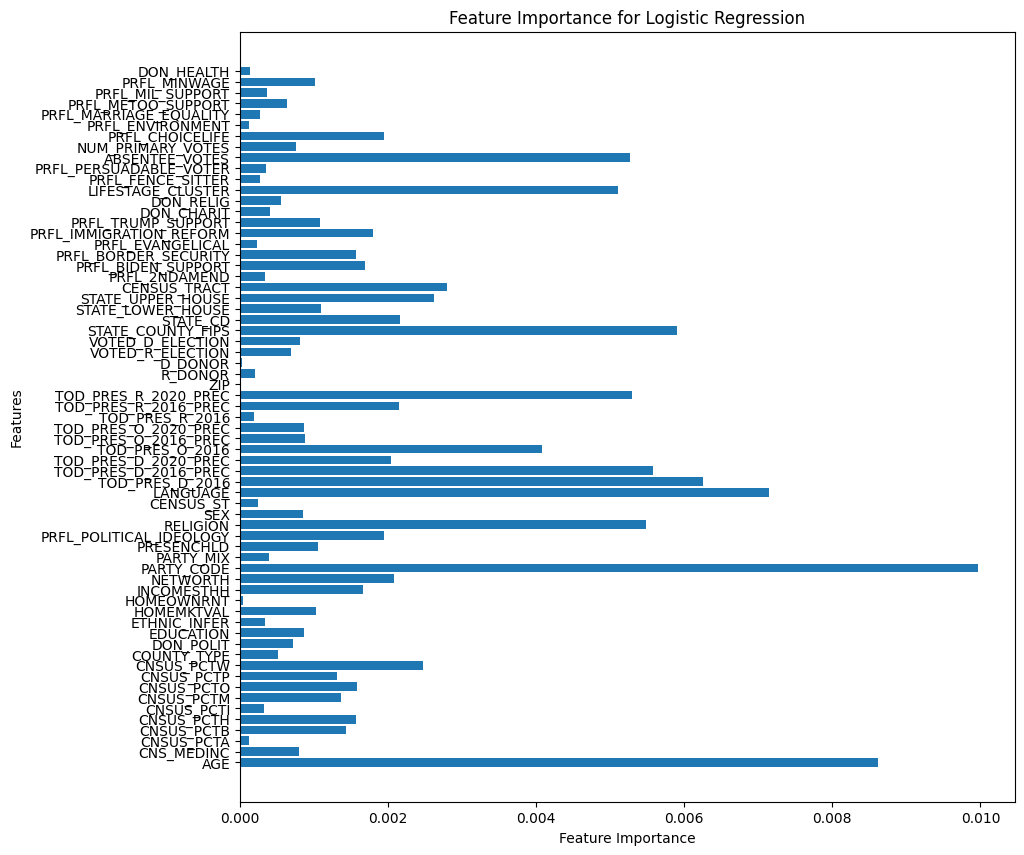

In [217]:
#feature importances

coefficients = log_reg.coef_[0]
feature_importance = np.abs(coefficients) 
features = features_to_use

plt.figure(figsize=(10, 10))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Logistic Regression')
plt.show()

# Random Forest

In [218]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.5666666666666667
              precision    recall  f1-score   support

           0       0.30      0.14      0.20        69
           1       0.53      0.68      0.60        98
           2       0.69      0.74      0.71       103

    accuracy                           0.57       270
   macro avg       0.51      0.52      0.50       270
weighted avg       0.53      0.57      0.54       270



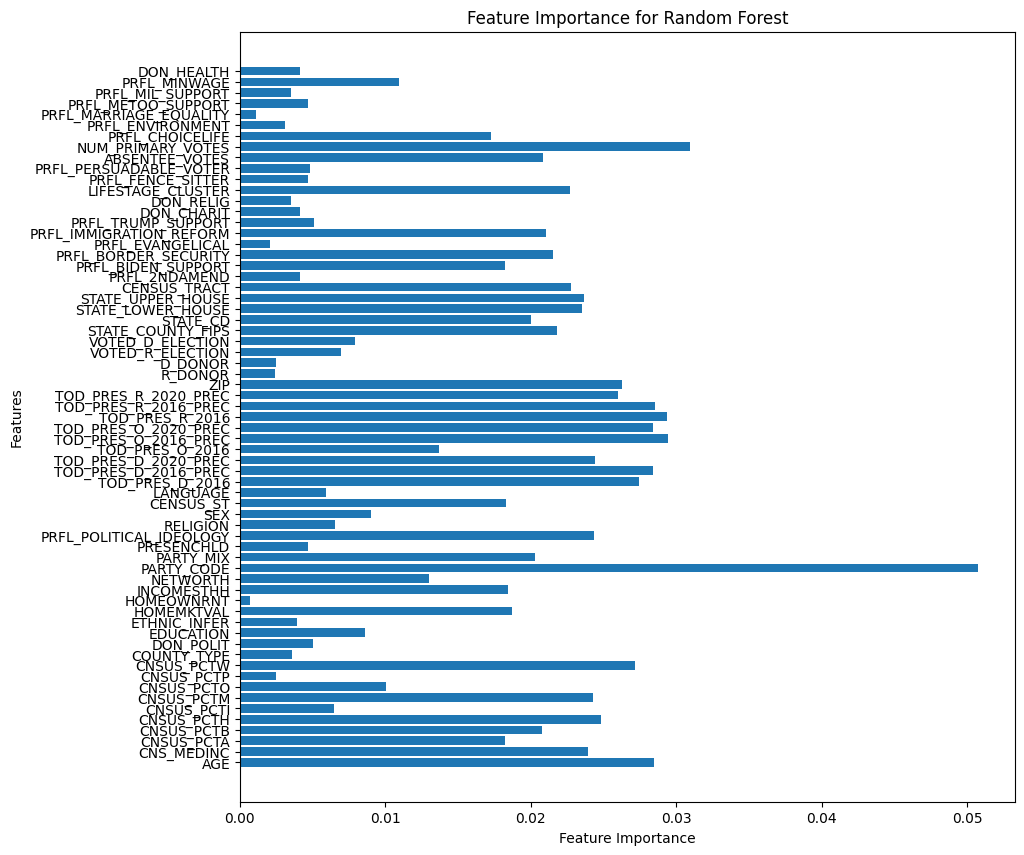

In [219]:
#feature importances

importances = rf_clf.feature_importances_
features = features_to_use


plt.figure(figsize=(10, 10))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Forest')
plt.show()

# SVM 

In [ ]:
#this is running for a long time
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

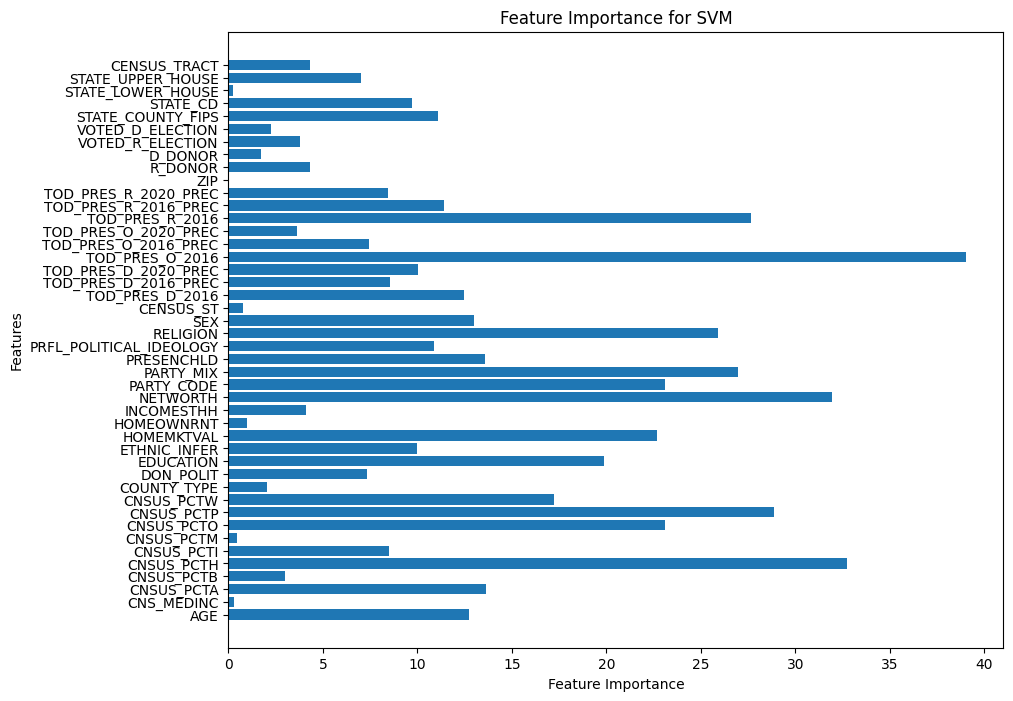

In [95]:
#feature importances

coefficients = svm_clf.coef_[0]
feature_importance = np.abs(coefficients)

features = features_to_use

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for SVM')
plt.show()


# GBDT

In [220]:

gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbt_model.fit(X_train, y_train)
y_pred = gbt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.59%
              precision    recall  f1-score   support

           0       0.46      0.28      0.35        69
           1       0.56      0.69      0.62        98
           2       0.67      0.70      0.68       103

    accuracy                           0.59       270
   macro avg       0.56      0.56      0.55       270
weighted avg       0.58      0.59      0.57       270



# GBDT Parameter Tuning

In [20]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1],
    'max_features': [None, 'sqrt', 'log2']
}

gbt = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Re-evaluate on the test set
best_gbt = grid_search.best_estimator_
y_pred = best_gbt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set Accuracy: {accuracy:.2f}")

Best parameters found: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 1}
Best cross-validation score: 0.57
Test set Accuracy: 0.58


In [221]:
gbt_modelt = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, max_features= 'sqrt', n_estimators= 50, subsample= 1)
gbt_modelt.fit(X_train, y_train)
y_pred = gbt_modelt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}%")

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.58%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.52      0.81      0.63        98
           2       0.66      0.76      0.70       103

    accuracy                           0.58       270
   macro avg       0.39      0.52      0.45       270
weighted avg       0.44      0.58      0.50       270



C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

# GBDT Feature Importances

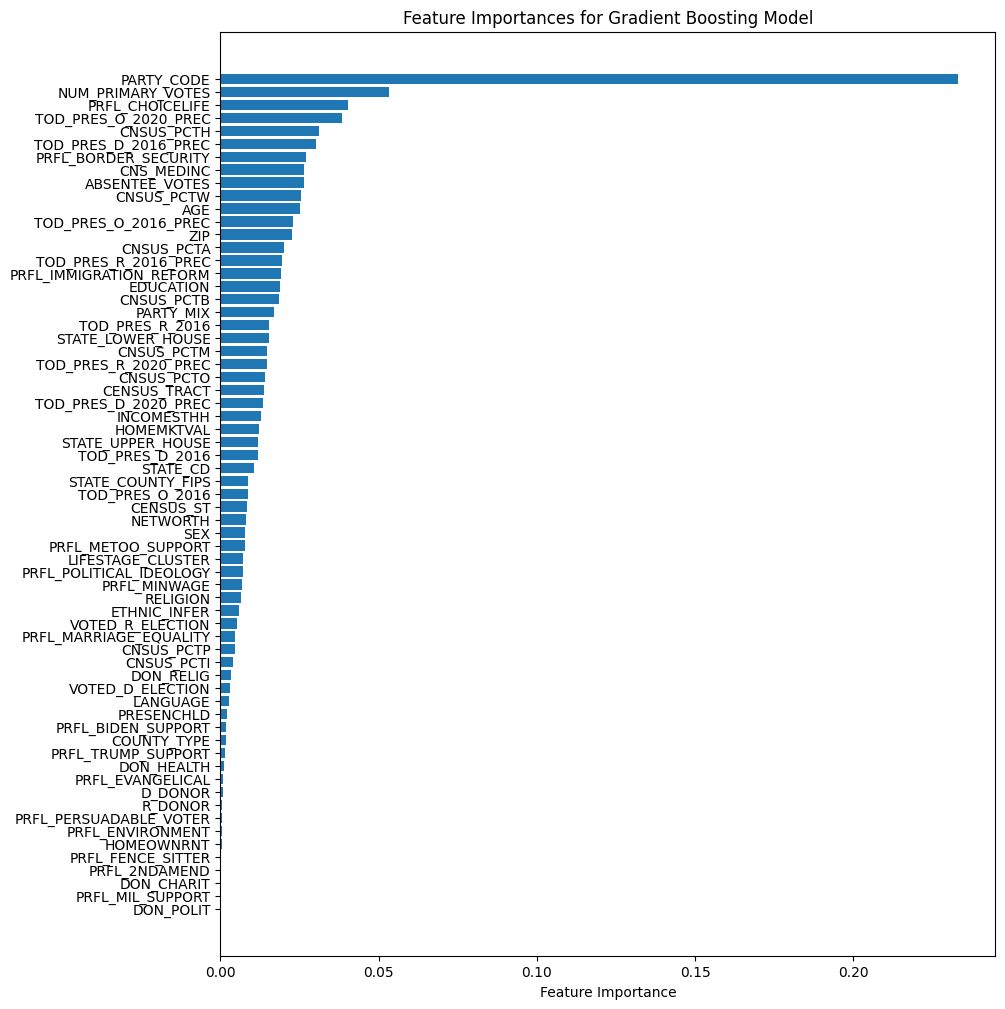

In [222]:

# Get feature importances
feature_importances = gbt_model.feature_importances_

feature_names = X.columns

# Sort features by importance
sorted_idx = feature_importances.argsort()

# Plot feature importances
plt.figure(figsize=(10, 12))
plt.barh(range(X.shape[1]), feature_importances[sorted_idx])
plt.yticks(range(X.shape[1]), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importances for Gradient Boosting Model')
plt.show()